## Character-level recurrent sequence-to-sequence model

Example from https://keras.io/examples/nlp/lstm_seq2seq/  
Older post https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

In [13]:
import numpy as np
import pandas as pd
import pydot as pyd
from itertools import chain
from Levenshtein import *
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from tensorflow import keras 
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, \
    multiply, concatenate, Flatten, Activation, dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 8)

In [4]:
with np.load('data/ncbi_02/dataset.npz', allow_pickle = True) as data:
    encoder_input_data = data['encoder_input_data']
    decoder_input_data = data['decoder_input_data']
    decoder_target_data = data['decoder_target_data']
    token_index = data['token_index'].tolist()

In [5]:
print(encoder_input_data.shape)
print(decoder_input_data.shape)
print(decoder_target_data.shape)
print(token_index)

(4368, 3822, 4)
(4368, 3822, 4)
(4368, 3822, 4)
{'A': 0, 'C': 1, 'G': 2, 'T': 3}


In [6]:
X_data = encoder_input_data[:1000]
Y_data = decoder_input_data[:1000]
print("X_data", X_data.shape)
print("Y_data", Y_data.shape)

X_data (1000, 3822, 4)
Y_data (1000, 3822, 4)


## Construct model

In [11]:
latent_dim = 256     # Latent dimensionality of the encoding space.

In [12]:
input_train = Input(shape=(X_data.shape[1], X_data.shape[2]))
output_train = Input(shape=(Y_data.shape[1], Y_data.shape[2]))
print(input_train)
print(output_train)

KerasTensor(type_spec=TensorSpec(shape=(None, 3822, 4), dtype=tf.float32, name='input_3'), name='input_3', description="created by layer 'input_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 3822, 4), dtype=tf.float32, name='input_4'), name='input_4', description="created by layer 'input_4'")


In [13]:
encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(
    latent_dim, dropout = 0.05, recurrent_dropout = 0.05, # , activation = 'elu'
    return_sequences = False, return_state = True)(input_train)
print(encoder_last_h1)
print(encoder_last_h2)
print(encoder_last_c)

KerasTensor(type_spec=TensorSpec(shape=(None, 256), dtype=tf.float32, name=None), name='lstm_1/strided_slice_3:0', description="created by layer 'lstm_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 256), dtype=tf.float32, name=None), name='lstm_1/while:4', description="created by layer 'lstm_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 256), dtype=tf.float32, name=None), name='lstm_1/while:5', description="created by layer 'lstm_1'")


In [14]:
encoder_last_h1 = BatchNormalization(momentum = 0.6)(encoder_last_h1)
encoder_last_c = BatchNormalization(momentum = 0.6)(encoder_last_c)

In [15]:
decoder = RepeatVector(Y_data.shape[1])(encoder_last_h1)
decoder = LSTM(
    latent_dim, dropout = 0.05, recurrent_dropout = 0.05, # , activation = 'elu'
    return_state = False, return_sequences = True)(
    decoder, initial_state = [encoder_last_h1, encoder_last_c])
print(decoder)

KerasTensor(type_spec=TensorSpec(shape=(None, 3822, 256), dtype=tf.float32, name=None), name='lstm_2/transpose_1:0', description="created by layer 'lstm_2'")


In [16]:
out = TimeDistributed(Dense(Y_data.shape[2], activation = "softmax"))(decoder)
print(out)

KerasTensor(type_spec=TensorSpec(shape=(None, 3822, 4), dtype=tf.float32, name=None), name='time_distributed/Reshape_1:0', description="created by layer 'time_distributed'")


In [17]:
model = Model(inputs = input_train, outputs = out)
opt = keras.optimizers.Adam(learning_rate = 0.01, clipnorm = 1)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 3822, 4)]    0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 256), (None, 267264      input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 256)          1024        lstm_1[0][0]                     
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 3822, 256)    0           batch_normalization_2[0][0]      
______________________________________________________________________________________________

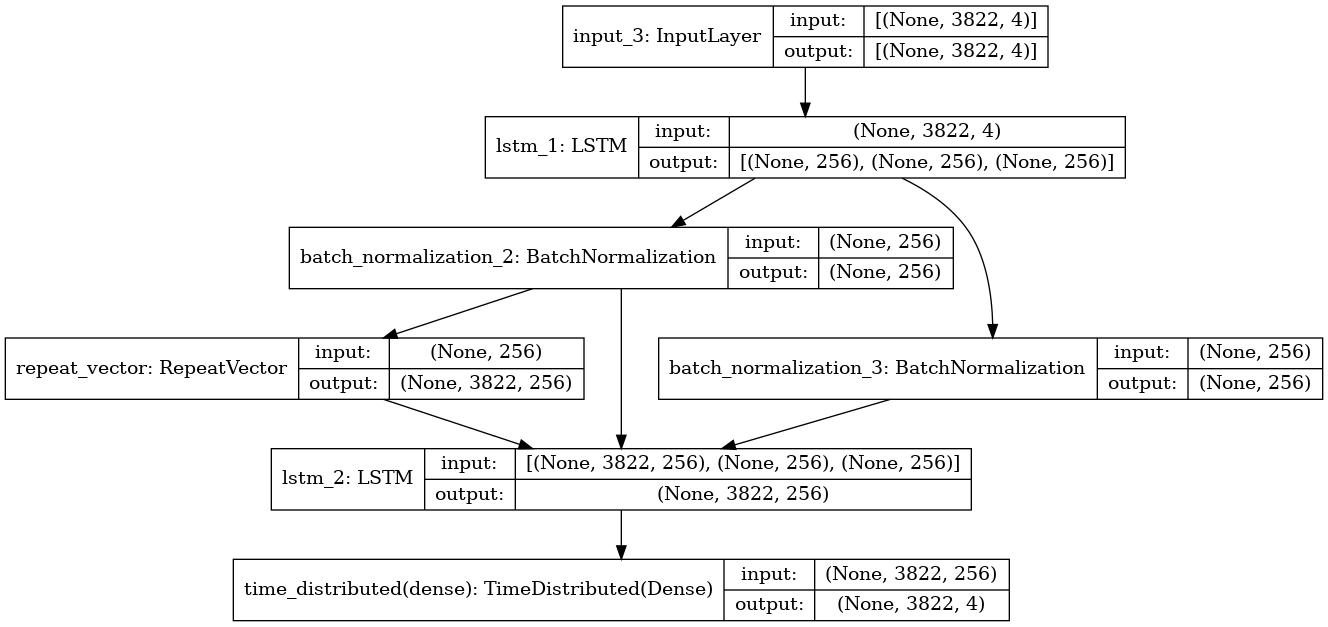

In [18]:
keras.utils.plot_model(model, to_file = 'model_plot.png', show_shapes = True, show_layer_names = True)

## Train model

In [19]:
batch_size = 128      # Batch size for training.
patience = 10        # Patience for EarlyStop
epochs = 1000        # Number of epochs to train for.

In [20]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = patience, restore_best_weights = True)
history = model.fit(X_data, Y_data, validation_split = 0.2, 
                    epochs = epochs, verbose = 1, callbacks = [ es ], 
                    batch_size = batch_size)
train_mae = history.history['accuracy']
valid_mae = history.history['val_accuracy']

2021-11-11 17:42:36.060166: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-11 17:42:36.078278: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3600000000 Hz


Epoch 1/1000
7/7 [==============================] - 146s 20s/step - loss: 1.5487 - accuracy: 0.2596 - val_loss: 1.3800 - val_accuracy: 0.2941
Epoch 2/1000
7/7 [==============================] - 138s 20s/step - loss: 1.3642 - accuracy: 0.3243 - val_loss: 1.3861 - val_accuracy: 0.3323
Epoch 3/1000
7/7 [==============================] - 137s 20s/step - loss: 1.3565 - accuracy: 0.3257 - val_loss: 1.3557 - val_accuracy: 0.3320
Epoch 4/1000
7/7 [==============================] - 135s 19s/step - loss: 1.3537 - accuracy: 0.3314 - val_loss: 1.3527 - val_accuracy: 0.3330
Epoch 5/1000
7/7 [==============================] - 135s 19s/step - loss: 1.3528 - accuracy: 0.3327 - val_loss: 1.3525 - val_accuracy: 0.3330
Epoch 6/1000
7/7 [==============================] - 136s 19s/step - loss: 1.3526 - accuracy: 0.3327 - val_loss: 1.3525 - val_accuracy: 0.3330
Epoch 7/1000
7/7 [==============================] - 136s 19s/step - loss: 1.3525 - accuracy: 0.3330 - val_loss: 1.3525 - val_accuracy: 0.3330
Epoch 

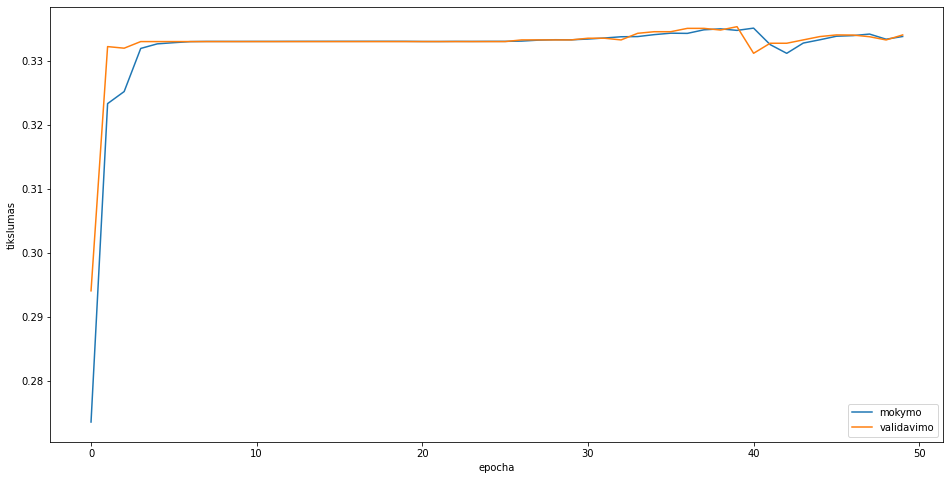

In [21]:
plt.plot(history.history['accuracy'], label = 'mokymo')
plt.plot(history.history['val_accuracy'], label = 'validavimo')
plt.ylabel('tikslumas')
plt.xlabel('epocha')
plt.legend()
plt.show()

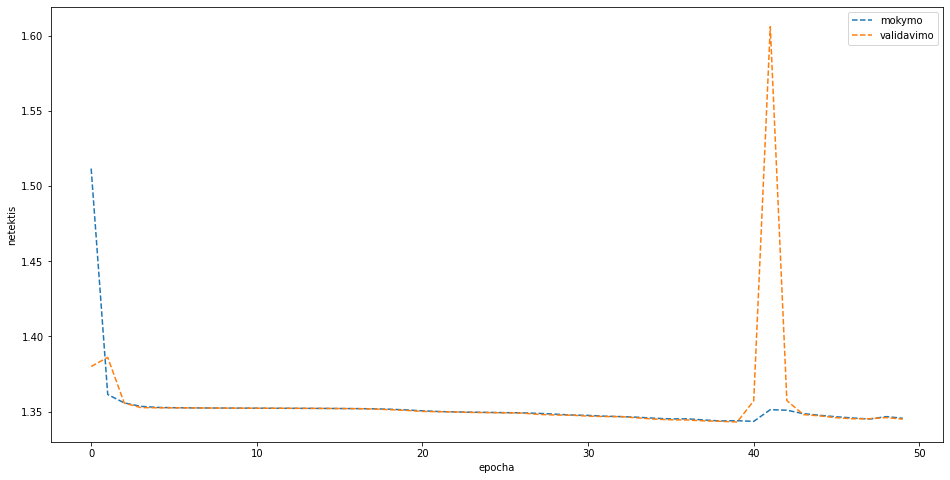

In [22]:
plt.plot(history.history['loss'], '--', label = 'mokymo')
plt.plot(history.history['val_loss'], '--', label = 'validavimo')
plt.ylabel('netektis')
plt.xlabel('epocha')
plt.legend()
plt.show()

In [41]:
model.save("data/ncbi_02/lstm_gen_1000seqs")

INFO:tensorflow:Assets written to: data/ncbi_02/lstm_gen_1000seqs/assets


In [8]:
model = keras.models.load_model("data/ncbi_02/lstm_gen_1000seqs")

In [9]:
print(X_data.shape)
print(Y_data.shape)

(1000, 3822, 4)
(1000, 3822, 4)


In [10]:
Y_pred = model.predict(X_data)
print(Y_pred.shape)

2021-11-12 10:28:35.709009: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(1000, 3822, 4)


In [11]:
reverse_char_index = dict((i, char) for char, i in token_index.items())
decode_seq = lambda seq: [ ''.join([ reverse_char_index[i] for i in s ]) for s in np.argmax(seq, axis = 2)]

In [14]:
cce = []
for i in tqdm(range(len(Y_data))):
    _ = keras.losses.CategoricalCrossentropy()(Y_data[i:i + 1], Y_pred[i:i + 1]).numpy()
    cce.append(_)
cce = np.array(cce)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 850.38it/s]


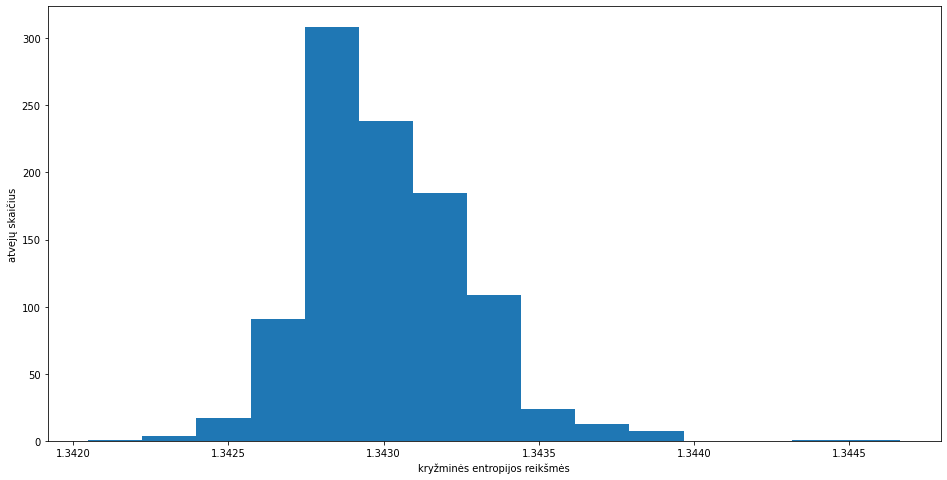

In [15]:
plt.hist(cce, bins = 15)
plt.xlabel('kryžminės entropijos reikšmės')
plt.ylabel('atvejų skaičius')
plt.show()

In [16]:
decoder_target_sequences = decode_seq(Y_data)
decoder_output_sequences = decode_seq(Y_pred)

In [17]:
lev_distances = [ distance(x,y) for x,y in zip(decoder_target_sequences, decoder_output_sequences) ]
lev_ratio = [ ratio(x,y) for x,y in zip(decoder_target_sequences, decoder_output_sequences) ]
ham_distances = [ hamming(x,y) for x,y in zip(decoder_target_sequences, decoder_output_sequences) ]

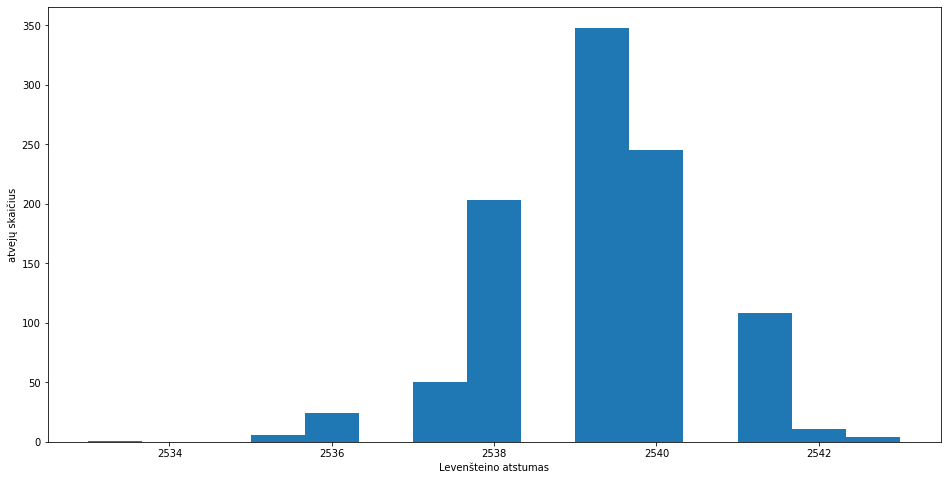

In [18]:
plt.hist(lev_distances, bins = 15)
plt.xlabel('Levenšteino atstumas')
plt.ylabel('atvejų skaičius')
plt.show()

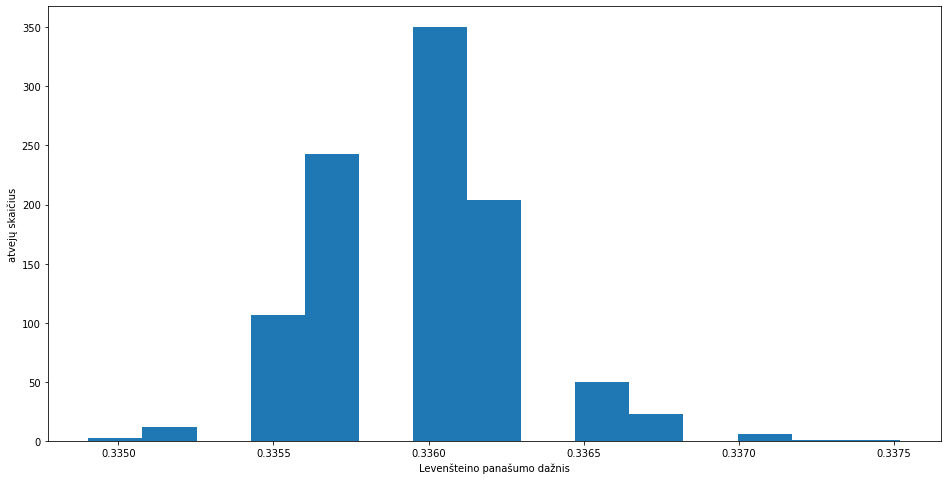

In [19]:
plt.hist(lev_ratio, bins = 15)
plt.xlabel('Levenšteino panašumo dažnis')
plt.ylabel('atvejų skaičius')
plt.show()

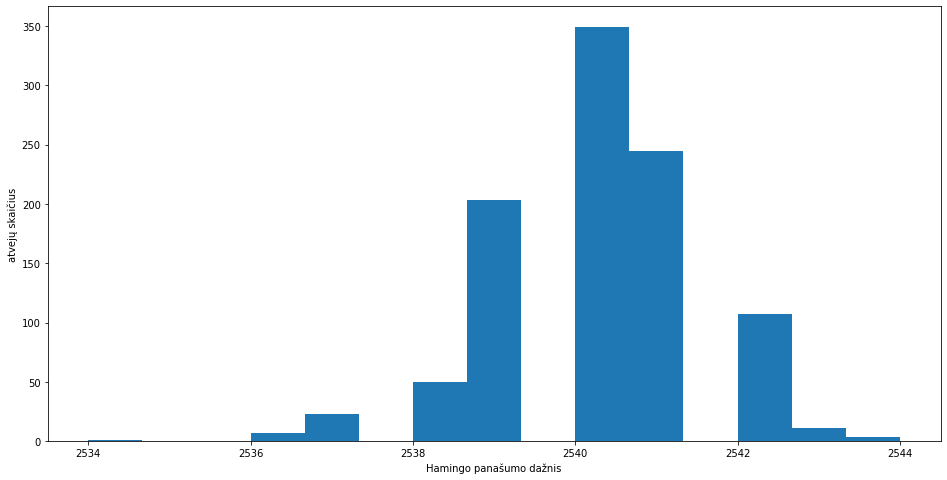

In [20]:
plt.hist(ham_distances, bins = 15)
plt.xlabel('Hamingo panašumo dažnis')
plt.ylabel('atvejų skaičius')
plt.show()

In [24]:
decoder_target_sequences[0]
#decoder_output_sequences

'ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTGTTAATCTTACAACCAGAACTCAATTACCCCCTGCATACACTAATTCTTTCACACGTGGTGTTTATTACCCTGACAAAGTTTTCAGATCCTCAGTTTTACATTCAACTCAGGACTTGTTCTTACCTTTCTTTTCCAATGTTACTTGGTTCCATGCTATACATGTCTCTGGGACCAATGGTACTAAGAGGTTTGATAACCCTGTCCTACCATTTAATGATGGTGTTTATTTTGCTTCCACTGAGAAGTCTAACATAATAAGAGGCTGGATTTTTGGTACTACTTTAGATTCGAAGACCCAGTCCCTACTTATTGTTAATAACGCTACTAATGTTGTTATTAAAGTCTGTGAATTTCAATTTTGTAATGATCCATTTTTGGGTGTTTATTACCACAAAAACAACAAAAGTTGGATGGAAAGTGAGTTCAGAGTTTATTCTAGTGCGAATAATTGCACTTTTGAATATGTCTCTCAGCCTTTTCTTATGGACCTTGAAGGAAAACAGGGTAATTTCAAAAATCTTAGGGAATTTGTGTTTAAGAATATTGATGGTTATTTTAAAATATATTCTAAGCACACGCCTATTAATTTAGTGCGTGATCTCCCTCAGGGTTTTTCGGCTTTAGAACCATTGGTAGATTTGCCAATAGGTATTAACATCACTAGGTTTCAAACTTTACTTGCTTTACATAGAAGTTATTTGACTCCTGGTGATTCTTCTTCAGGTTGGACAGCTGGTGCTGCAGCTTATTATGTGGGTTATCTTCAACCTAGGACTTTTCTATTAAAATATAATGAAAATGGAACCATTACAGATGCTGTAGACTGTGCACTTGACCCTCTCTCAGAAACAAAGTGTACGTTGAAATCCTTCACTGTAGAAAAAGGAATCTATCAAACTTCTAACTTTAGAGTCCAACCAACAGAATCTATTGTTAGATTTCCTAATATTACA

In [25]:
decoder_output_sequences[0]

'ATGTTTGTTTTTCTTGTTTTATTGCTACTACTACTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT